# Optimization of compute bound Python code 

## Layout:

* Forword about optimization and profiling:
    - No optimisation without profiling
    - No benchmarking without tests
* Presentation of the example:
    - Square crystal: demonstration
    - Relaxated circular crystal: exercise
* `Python` version:
    - code with loops ala `FORTRAN`
    - Bottleneck search
* `Numpy` vectorized version:
    - Limits of vectorization: cache sizes
[...]

* `Numexpr` compiler for mathematical formula
    - Single and multi-threaded evaluation
    - Limits of `numexpr`
* `Numba`: just in time compilation of numerical code
    - Decoration of function
    - Type annotation
    - Limits of `numba`
* `Cython`: ahead of time compilation
    - `Cython` usage within `Jupyter`
    - Annotated compilation 
    - Single threaded performances
    - Parallelization with OpenMP
    - Mixing Extensions with Python threads
* Conclusions:
    - Only addresses CPU-bound issues, not I/O issues
    - If you problem is still CPU-bound, is possible when moving to GPU

## Definitions:
* In computer science, software **optimization** is the process of modifying a software system to make some aspect of it work more efficiently or use fewer resources.[Wikipedia]
* In software engineering, software **profiling** is a form of dynamic program analysis that measures, for example, the space (memory) or time complexity of a program, the usage of particular instructions, or the frequency and duration of function calls. Most commonly, profiling information serves to aid program optimization, and more specifically, performance engineering. [Wikipedia]
* Regression **testing** is re-running functional and non-functional tests to ensure that previously developed and tested software still performs after a change. If not, that would be called a regression.

## Profiling in Python

The standard library of *Python* contains the **cProfile** module which collects information about the running code. It is a *C* version of the *profile* module.

Profiling induces slow-down, it should be distinguished from form *benchmarking*.

Profile results can be analyzed with the *pstats* module or exernal programs like **RunSnakeRun**, **SnakeViz** or **kcachegrind**. 

In [1]:
import math, cProfile
prf = cProfile.Profile()
prf.enable() # Start of the profiled section:
size = 1000000
distance = 1; tth = []
for i in range(size):
    x_i = size//1000/1000
    y_i = size%1000/1000
    radius = math.sqrt(x_i**2 + y_i**2)
    tth.append(math.atan2(radius, distance))
prf.disable() #End of section:
prf.dump_stats("profile.log"); prf.print_stats() # Save / display some results

         3000110 function calls in 0.925 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-1-fa60611d6caf>:11(<module>)
        1    0.000    0.000    0.000    0.000 <ipython-input-1-fa60611d6caf>:4(<module>)
        1    0.000    0.000    0.000    0.000 <ipython-input-1-fa60611d6caf>:5(<module>)
        1    0.674    0.674    0.925    0.925 <ipython-input-1-fa60611d6caf>:6(<module>)
        5    0.000    0.000    0.000    0.000 codeop.py:132(__call__)
       10    0.000    0.000    0.000    0.000 compilerop.py:138(extra_flags)
        5    0.000    0.000    0.000    0.000 contextlib.py:108(__enter__)
        5    0.000    0.000    0.000    0.000 contextlib.py:117(__exit__)
        5    0.000    0.000    0.000    0.000 contextlib.py:238(helper)
        5    0.000    0.000    0.000    0.000 contextlib.py:82(__init__)
        5    0.000    0.000    0.000    0.000 hook

Example of visualization of the profiling with **runSnakeRun** or **SnakeViz**. Equivalent visualization is available from the other tools.

This is the typical way of using the Python profiler. Another way to use it is to invoque it when starting the process:

`python -m cProfile -o profile.log myscript.py`

There is also the `%prun` magic jupyter command to run the line/cell with the profiler enabled.

In [2]:
#!snakeviz profile.log

## Two-dimensional Laue function example

All this training is based on the same example: 2D diffraction from a finite size crystallite given by Laue function:

$$ I(H,K) = \left | \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \exp \left [ 2 \pi i \left ( H n + K m \right ) \right ] \right| ^2 $$

This equation describes the scattering from square crystal having *N* unit-cells in both directions; *n* and
*m* are the indices of the unit-cell in each direction and *H* and *K* are the continuous Miller indices which are sampled in the neighborhood of *H,K* [H-0.5:H+0.5, K-0.5:K+0.5] to build an image of the diffraction peak.

This example is derived from: https://journals.iucr.org/j/issues/2019/04/00/gj5229/gj5229.pdf

In [3]:
%matplotlib inline 
# This is for plotting
import os
import math
import cmath
import cpuinfo
import numpy as np
from matplotlib.pyplot import subplots
from matplotlib.colors import LogNorm

In [4]:
# Description of the system:
n_cpu = os.cpu_count()
print(f"We are working on a computer with {n_cpu} cores")
#Reduce this number if you have booked only a smaller number of cores
n_cpu = 6; print(f"We are using only {n_cpu} cores") 
for key, val in cpuinfo.get_cpu_info().items():
    if "cache_size" in key:
        print(key, val)

We are working on a computer with 12 cores
We are using only 6 cores
l3_cache_size 15728640
l2_cache_size 262144
l1_data_cache_size 32768
l1_instruction_cache_size 32768


In [5]:
#Some constants valid for all calculation
#Miller index of reflection
H = 0 
#Miller index of reflection
K = 4 
#Number of units cells per direction
N = 32 
#Defines how much points are needed to describe a single Laue fringe (2 = Nyquist frequency)
oversampling = 3
#Maximum strain at surface
e0 = 0.01 
#Width of the strain profile below the surface
w = 5. 

#Generate real and reciprocal space coordinates
n = np.arange(N)
m = np.arange(N)
h = np.arange(H-0.5, H+0.5, 1./(oversampling*N))
k = np.arange(K-0.5, K+0.5, 1./(oversampling*N))

In [6]:
def Laue_python(n, m, h, k):
    result = [[0 for x in range(len(h))] for y in range(len(k))]
    for i_h, v_h in enumerate(h):  # loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = 0.0
            for i_n in n:  # loop and sum over unit-cells
                for i_m in m:
                    tmp += cmath.exp(2j*np.pi*(v_h*i_n + v_k*i_m))
            result[i_h][i_k] = abs(tmp)**2
    return np.array(result)

#Compute
%time square_intensity = Laue_python(n, m, h, k)

CPU times: user 6.03 s, sys: 415 µs, total: 6.03 s
Wall time: 6.04 s


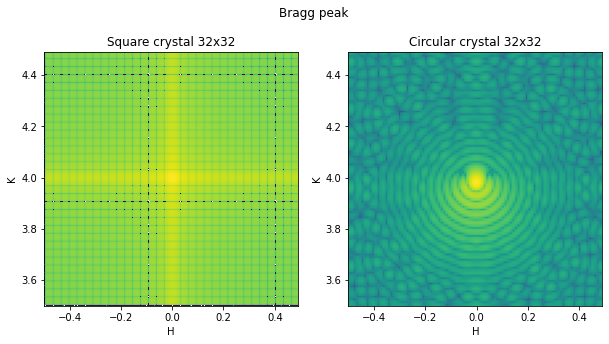

In [7]:
# Visualization of the reference images
fig, ax = subplots(1,2, figsize=(10,5))
fig.suptitle("Bragg peak")
ax[0].imshow(np.load("reference_sq.npy").T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
ax[0].set_xlabel('H')
ax[0].set_ylabel('K')
ax[0].set_title(f"Square crystal {N}x{N}")
ax[1].imshow(np.load("reference_ci.npy").T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
ax[1].set_xlabel('H')
ax[1].set_ylabel('K')
ax[1].set_title(f"Circular crystal {N}x{N}")
pass

### Validation of optimization

Code optimization should always be performed with some tests to ensure the speed-up obtained is not degrading the numerical quality !

In [8]:
# Validation of the result:
def validate_sq(result):
    "Return the error value"
    reference = np.load("reference_sq.npy")
    return abs(reference-result).max()/reference.max()

# Validation of the result (for the exercises):
def validate_ci(result):
    "Return the error value"
    reference = np.load("reference_ci.npy")
    return abs(np.array(reference)-result).max()/reference.max()

def display(result):
    "Display the array"
    fig, ax = subplots()
    fig.suptitle("Bragg peak")
    ax.imshow(result.T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
    ax.set_xlabel('H')
    ax.set_ylabel('K')
    ax.set_title(f"Crystal {N}x{N}")
    
    
print("Error measured:", validate_sq(square_intensity))

Error measured: 4.218847493575595e-15


In [9]:
#Measure performances of the Python implementation
perf_sq_python = %timeit -o Laue_python(n, m, h, k)

5.95 s ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Exercise:

Let's consider the case where the crystal is not a square and atoms are not perfectly ordered and
exhibits some strain. 

The first point implies that the unit-cell coordinates cannot be simply represented by a
array, and it is necessary to introduce a support function, `Omega`, equal to one when the unit-cell coordinate is located inside the crystal, and zero outside.

1. Write a function generating the diffraction from a **circular** 2D crystal (inscribed in the square considered previously). One may consider the radius of the disk to be $R=N/2$.

The previous formula becomes then:
$$ I(H,K) = \left | \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \Omega \left (n,m \right ) \exp \left \{ 2 \pi i \left [ H n + K m) \right ] \right \} \right | ^2$$
With the support function defined as: 
* $ \Omega \left (n,m \right ) = 0$  where $(n-N/2)^2+(m-N/2)^2>(N/2)^2$.
* $ \Omega \left (n,m \right ) = 1$  where $(n-N/2)^2+(m-N/2)^2 \leq (N/2)^2$.

How do those modifications affect the execution speed ?

The second point implies that unit-cells are shifted from their regular position according to $n’ = n + Δn$, where $Δn$ is the displacement.
For the case of a circular crystal, a function describing a progressive dilatation when moving from the
center towards the periphery can be written:

$$  \overrightarrow{\Delta r}(\overrightarrow{r}) = e_{0} \overrightarrow{r} (1 + tanh(\frac{r-R}{w})) $$

where Δr(r) is the displacement of the unit-cell located at a distance r from the crystal center, $e_0$ is the
maximum strain, and w is a parameter describing the width of the displacement profile (for small
values of w the strain is confined at the periphery of the crystal, whereas large values also affect the
interior of the crystal).

2. Modify the function to take into account the displacement induced by the strain.

The previous formula becomes then:
$$ I(H,K) = \left | \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \Omega \left (n,m \right ) \exp \left \{ 2 \pi i \left [ H \left (n + \Delta n\right )+ K \left (m + \Delta m\right ) \right ] \right \} \right | ^2$$




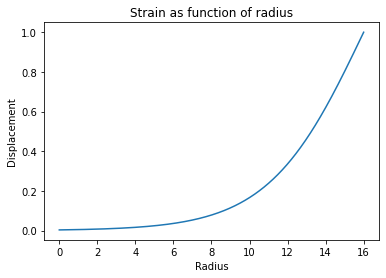

In [10]:
# Displacement of atoms as function of the radius
fig, ax = subplots()
x=np.linspace(0, N/2 , 1000)
ax.plot(x, 1+np.tanh((x-N/2)/w))
ax.set_xlabel("Radius")
ax.set_ylabel("Displacement")
t=ax.set_title("Strain as function of radius")

In [11]:
def Circ_python_1(n, m, h, k):
    x = np.atleast_2d(n-N/2)
    y = np.atleast_2d(m/N/2).T
    omega = x*x + y*y <=N*N/4
    result = [[0 for x in range(len(h))] for y in range(len(k))]
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            #One should discard  bad values
            tmp = 0.0
            for i_n in n:#loop and sum over unit-cells
                for i_m in m:
                    if omega[i_n, i_m]:
                        tmp += cmath.exp(2j*np.pi*(v_h*i_n + v_k*i_m))
            result[i_h][i_k] = abs(tmp)**2
    return np.array(result)

#Compute
%time intensity_circle = Circ_python_1(n, m, h, k)
print("Error:", validate_ci(intensity_circle))

CPU times: user 6.98 s, sys: 8.03 ms, total: 6.99 s
Wall time: 6.99 s
Error: 1.6782257638277525


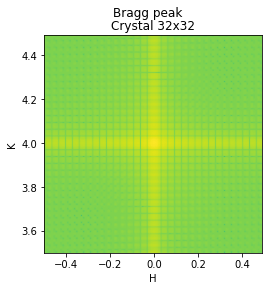

In [12]:
display(intensity_circle)

CPU times: user 5.3 s, sys: 8 ms, total: 5.3 s
Wall time: 5.31 s
5.24 s ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


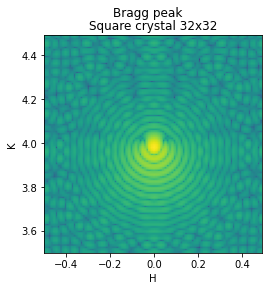

In [13]:
def Circ_python_2(n, m, h, k):
    N_2 = N / 2
    positions = {}
    for i in n:
        x = i - N_2
        for j in m:
            y = j - N_2
            r = (x*x + y*y)**0.5
            if r<=N_2:
                strain = e0 * (1 + math.tanh((r - N_2)/w))
                positions[(i,j)] = (i + strain*x,
                                    j + strain*y)
    result = [[0 for x in range(len(h))] for y in range(len(k))]
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            #One should discard  bad values
            tmp = 0.0
            for i_n in n:#loop and sum over unit-cells
                for i_m in m:
                    pos = positions.get((i_n, i_m))
                    if pos:
                        n_s, m_s = pos
                        tmp += cmath.exp(2j*np.pi*(v_h*n_s + v_k*m_s))
            result[i_h][i_k] = abs(tmp)**2
    return np.array(result)
%time intensity_circle = Circ_python_2(n, m, h, k)
# Visualization of the reference image
fig, ax = subplots()
ax.imshow(intensity_circle.T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
ax.set_xlabel('H')
ax.set_ylabel('K')
fig.suptitle("Bragg peak")
title = ax.set_title(f"Square crystal {N}x{N}")
Circ_python = Circ_python_2
perf_ci_python = %timeit -o Circ_python_2(n, m, h, k)

# Jupyter magick functions for profiling:

* `%time`: Measures the time to run the function, once
* `%timeit`: Measures the time in benchmarking mode (many repetitions, garbage collector disabled, ...)
* `%prun`: run withing the profiler
* `%lprun`: run with the line-profiler active
* `%mprun`: run with memory profile

All those functions can be used with `%%` to apply to the full cell instead of a single command.
    
Mind to ask for their help ... sometimes they have multiple options `%timeit?`

In [14]:
# Run a function in the Python profiler ...
%prun -D square.log Laue_python(n, m, h, k)

 
*** Profile stats marshalled to file 'square.log'. 


In [15]:
# Line profiler:
%load_ext line_profiler
%lprun -f Laue_python Laue_python(n, m, h, k)

In [16]:
#Memory profiler
%load_ext memory_profiler
%memit Laue_python(n, m, h, k)

peak memory: 133.13 MiB, increment: 0.19 MiB


**Exercise:** Profile your strained crystal diffraction with `%prun` and `%lprun` and `%memit`.

In [17]:
%prun -D circle.log Circ_python(n, m, h, k)

 
*** Profile stats marshalled to file 'circle.log'. 


In [18]:
%lprun -f Circ_python Circ_python(n, m, h, k)

In [19]:
%memit Circ_python(n, m, h, k)

peak memory: 133.15 MiB, increment: 0.00 MiB


## Optimization with `NumPy`

Python is a dynamic language and is known to be pretty inefficient when looping over large datasets.
The `numpy` library offers vectorial notation which avoid those loops.

This is how the previous function writes in a fully vectorial way:

In [20]:
def Laue_numpy(n, m, h, k):
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    return np.abs(np.exp(2j*np.pi*(h*n + k*m)).sum(axis=(2,3)))**2

#Compute and check error
%time intensity = Laue_numpy(n, m, h, k)
print("Error:", validate_sq(intensity))

CPU times: user 298 ms, sys: 40 ms, total: 338 ms
Wall time: 336 ms
Error: 0.0


The first striking observation is that the code is much more concise. 

It is also much clearer since the actual calculation requires one line (line 6) with a syntax similar to the provided Equation. 

Lines 2-5 add new (empty) dimensions to the input arrays. With this transformation the calculation of h*n + k*m actually returns a 4-dimensional array. This important feature of NumPy is known as “broadcasting”. 
The exponential then operates on all cells of this array,
and the sum over the real-space coordinates is performed using the sum() method of the NumPy arrays,
line 6 (the “ axis=(2,3) ” argument designates the fact that the summation has to be performed over the
last two dimensions of the array that contain the real space variables). 

Besides the cleaner syntax, this implementation is also much faster than Python code.

In [21]:
perf_sq_numpy = %timeit -o Laue_numpy(n, m, h, k)

350 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Exercise:** Implement the strained crystal diffraction using `NumPy`.

In [22]:
def Circ_numpy(n, m, h, k):
    N = n.size
    N_2 = N/2
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    radius = np.sqrt((n-N_2)**2 + (m-N_2)**2)
    strain = e0 * (1.0 + np.tanh((radius - N_2)/w))
    p_n = n + strain*(n-N_2)
    p_m = m + strain*(m-N_2)
    omega = radius <= N_2    
    tmp = omega * np.exp(2j*np.pi*(h*p_n + k*p_m))
    return np.abs(tmp.sum(axis=(2,3)))**2

#Compute and check error
%time intensity = Circ_numpy(n, m, h, k)
print("Error:", validate_ci(intensity))
perf_ci_numpy = %timeit -o Circ_numpy(n, m, h, k)

CPU times: user 365 ms, sys: 32 ms, total: 397 ms
Wall time: 396 ms
Error: 0.0
410 ms ± 5.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Limits of `numpy`'s vectorization

When calculating expression like "a+2*b+5*c+a*b", each individual operation creates a new temporary array where all results of each binary operation are stored. This can be an issue when the number of operand is large and that those temporary array are larger than the cache size of the processor. Those temporary array needs to go back to central memory before starting next operation and this is bad for performances.

In [23]:
#Importance of the cache:
def tmp_numpy(n, m, h, k):
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    return np.exp(2j*np.pi*(h*n + k*m))
print("Size of the intermediate array: ", tmp_numpy(n,m,h,k).nbytes)

Size of the intermediate array:  150994944


In [24]:
%memit Laue_numpy(n, m, h, k)

peak memory: 411.27 MiB, increment: 278.02 MiB


## `NumExpr` is a fast numerical expression evaluator for `NumPy`.

It works best for evaluating large numerical expressions on arrays which do not fit into cache. The speed-up is typically of the order of 4-8x (may be limited by the number of cores since `numexpr` uses all cores).

In [25]:
import numexpr as ne
ne.set_num_threads(n_cpu)  # Limit the number of threads to be used

a = np.arange(10)
ne.evaluate("sin(a)**2 + cos(a)**2")

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [26]:
def Laue_numexpr(n, m, h, k):
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    j2pi = np.pi*2j
    tmp = ne.evaluate("exp(j2pi*(h*n + k*m))")
    return np.abs(tmp.sum(axis=(2,3)))**2

#Compute and check error
%time intensity = Laue_numexpr(n, m, h, k)
print("Error:", validate_sq(intensity))

CPU times: user 438 ms, sys: 4.03 ms, total: 442 ms
Wall time: 86.4 ms
Error: 0.0


In [27]:
perf_sq_numexpr = %timeit -o Laue_numexpr(n, m, h, k)

73.6 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%memit Laue_numexpr(n, m, h, k)

peak memory: 277.97 MiB, increment: 144.00 MiB


**Exercise:** Implement the strained crystal diffraction using `NumExpr`.

In [29]:
def Circ_numexpr(n, m, h, k):
    N = n.size
    N_2 = N/2
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    radius = ne.evaluate("sqrt((n - N_2)**2 + (m - N_2)**2)")
    strain = ne.evaluate("e0 * (1 + tanh((radius-N_2) / w))")
    j2pi = np.pi*2j
    tmp = ne.evaluate("where(radius > N_2, 0, exp(j2pi*(h*(n+strain*(n-N_2)) + k*(m+strain*(m-N_2)))))")
    result = abs(tmp.sum(axis=(2,3)))**2
    return result

%time  intensity = Circ_numexpr(n, m, h, k)
print("Error:", validate_ci(intensity))
perf_ci_numexpr = %timeit -o Circ_numexpr(n, m, h, k)


CPU times: user 515 ms, sys: 3.99 ms, total: 519 ms
Wall time: 99.3 ms
Error: 0.0
85.9 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Limits of `NumExpr`:
* Limited to mathematical functions
* Limited to element-wise evaluation (reduction is under development)

## `Numba`, a high performance Python compiler
`Numba` is an open source, **Just In Time** compiler that translates a subset of `Python` and `NumPy` code into fast machine code using the `LLVM` compiler library.

`Numba` provides a `jit` decorator to indicate the function should be compiled. It usually performs better on explicit loops but accepts most of the `NumPy` constructions. The `jit` decorator takes those options:
* signature of the function
* nogil=True: the function should contains not more Python construct after compilation
* nopython=True: raise an exception when Python construct remain
* parallel=True: enable parallel excution with `numba.prange` instead of `range`. Requires `nogil` and `nopython`

In [30]:
import numba as nb
nb.set_num_threads(n_cpu) #Limit the number of cores to be used

@nb.jit
def test_one(a):
    result = np.zeros(a.shape)
    for i in range(a.size):
        result[i] = np.cos(a[i])**2 + np.sin(a[i])**2
    return result

%time test_one(a)
%timeit test_one(a)
test_one(a)

/users/kieffer/.venv/py38/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10006. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 727 ms, sys: 408 ms, total: 1.14 s
Wall time: 323 ms
699 ns ± 1.05 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [31]:
# Get the assembly code
for key, value in test_one.inspect_asm().items():
    print("Signature:", key)
    print("Machine code:\n",value)

Signature: (array(int64, 1d, C),)
Machine code:
 	.text
	.file	"<string>"
	.globl	_ZN8__main__12test_one$241E5ArrayIxLi1E1C7mutable7alignedE
	.p2align	4, 0x90
	.type	_ZN8__main__12test_one$241E5ArrayIxLi1E1C7mutable7alignedE,@function
_ZN8__main__12test_one$241E5ArrayIxLi1E1C7mutable7alignedE:
	.cfi_startproc
	pushq	%rbp
	.cfi_def_cfa_offset 16
	pushq	%r15
	.cfi_def_cfa_offset 24
	pushq	%r14
	.cfi_def_cfa_offset 32
	pushq	%r13
	.cfi_def_cfa_offset 40
	pushq	%r12
	.cfi_def_cfa_offset 48
	pushq	%rbx
	.cfi_def_cfa_offset 56
	subq	$40, %rsp
	.cfi_def_cfa_offset 96
	.cfi_offset %rbx, -56
	.cfi_offset %r12, -48
	.cfi_offset %r13, -40
	.cfi_offset %r14, -32
	.cfi_offset %r15, -24
	.cfi_offset %rbp, -16
	movq	104(%rsp), %r13
	testq	%r13, %r13
	js	.LBB0_1
	movq	%rdi, %rax
	imulq	$8, %r13, %rdi
	jo	.LBB0_7
	movq	%r8, %r12
	movq	%rax, 16(%rsp)
	movabsq	$NRT_MemInfo_alloc_safe_aligned, %rax
	movl	$32, %esi
	callq	*%rax
	movq	%rax, 8(%rsp)
	movq	24(%rax), %rbx
	leaq	(,%r13,8), %rdx
	movabsq	$memset

In [32]:
@nb.jit(parallel=True)
def Laue_numba(n, m, h, k):
    result = np.zeros((h.size, k.size), dtype=np.float64)
    for i in nb.prange(h.size): #loop over the reciprocal space coordinates
        for j in range(k.size):
            tmp = 0j
            for i_n in n: #loop and sum over unit-cells
                for i_m in m:
                    tmp +=  cmath.exp(2j*np.pi*(h[i]*i_n + k[j]*i_m))
            result[i, j] = abs(tmp)**2
    return result

#Compute and check error
%time intensity = Laue_numba(n, m, h, k)
print("Error:", validate_sq(intensity))

CPU times: user 1.19 s, sys: 7.86 ms, total: 1.2 s
Wall time: 939 ms
Error: 4.218847493575595e-15


In [33]:
perf_sq_numba = %timeit -o Laue_numba(n, m, h, k)

42.5 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
%memit Laue_numba(n, m, h, k)

peak memory: 221.24 MiB, increment: -5.98 MiB


**Exercise:** Implement the strained crystal diffraction using `Numba`.

In [35]:
@nb.jit(parallel=True)
def Circ_numba(n, m, h, k):
    result = np.zeros((h.size,k.size), dtype=np.float64)
    N = n.size
    N_2 = N/2
    for h_i in nb.prange(h.size): #loop over the reciprocal space coordinates
        for k_i in range(k.size):
            tmp = 0j
            for i_n in n:#loop and sum over unit-cells
                for i_m in m:
                    radius = math.sqrt((i_n - N_2)** 2 + (i_m - N_2)** 2)
                    if (radius > (N_2)):
                        value = 0j
                        #continue #Numba isn't working using the same continue pattern as below
                    else:
                        strain = e0 * (1 + math.tanh((radius-N_2)/w))
                        p_n = i_n + strain*(i_n - N_2)
                        p_m = i_m + strain*(i_m - N_2)
                        value = np.exp(2j*cmath.pi*(h[h_i]*p_n + k[k_i]*p_m))
                    tmp +=  value
            result[h_i, k_i] = abs(tmp)**2
    return result

%time intensity = Circ_numba(n, m, h, k)
print("Error:", validate_ci(intensity))
perf_ci_numba = %timeit -o  Circ_numba(n, m, h, k)

CPU times: user 1.43 s, sys: 11.9 ms, total: 1.44 s
Wall time: 888 ms
Error: 3.3097742436391504e-15
98.4 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Drawback of `Numba`
`Numba` being a JIT compiler, it requires the compiler `LLVM-lite` to be installed and configured on every single node.

The second drawback is the JIT: the compilation will be performed for the first execution of a session and if it runs on a cluster, the compilation will occure on every node. Numba is hence not mutli-processing friendly.

Finally the support for multi-threading in classes looks brittle, at least when evaluated.

## Cython C-extensions for Python

Static, ahead of time compiler for Python: compile Python code to C-extensions.

Normal Python code gets usually 30% speed up but for numerical kernels, native C-speed is achievable easily.
To get substential speed-up, one need to declare most variables and explicitly write loops. 

The methodology is pretty similar as for `numba`:
1. Write the code with loops
2. Use the `cython -a` to annotate the code to highlight potential hot-spots, in yellow.
3. Declare variables which are not infered with `cdef` and the proper type
4. Isolate the numerical kernel and replace numpy functions with

In [36]:
%load_ext Cython
# This enables the %cython mode

In [37]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp -a
#cython: embedsignature=True, language_level=3, binding=True
#cython: boundscheck=False, wraparound=False, cdivision=True, initializedcheck=False,
## This is for developping:
## cython: profile=True, warn.undeclared=True, warn.unused=True, warn.unused_result=False, warn.unused_arg=True

import numpy as np
from cython.parallel import prange
from libc.complex cimport cabs, cexp
    
def Laue_cython(long[::1] n, 
                long[::1] m, 
                double[::1] h, 
                double[::1] k):
    cdef:
        double[:, ::1] result
        double complex tmp, two_j_pi
        int i_h, i_k, i_m, i_n, h_size, k_size, n_size, m_size
        
    two_j_pi = np.pi*2j
    h_size = h.shape[0]
    k_size = k.shape[0]
    n_size = n.shape[0]
    m_size = m.shape[0]
    result = np.zeros((h_size, k_size))
    
    for i_h in prange(h_size, nogil=True):  # loop over the reciprocal space coordinates
        for i_k in range(k_size):
            tmp = 0.0
            for i_n in range(n_size):  # loop and sum over unit-cells
                for i_m in range(m_size):
                    tmp += cexp(two_j_pi*(h[i_h]*n[i_n] + k[i_k]*m[i_m]))
            result[i_h, i_k] += cabs(tmp)**2
    return np.asarray(result)

In [38]:
#Compute and check error
os.environ["OMP_NUM_THREADS"] = str(n_cpu)
%time intensity = Laue_cython(n, m, h, k)
print("Error:", validate_sq(intensity))
perf_sq_cython = %timeit -o Laue_cython(n, m, h, k)

CPU times: user 547 ms, sys: 183 µs, total: 547 ms
Wall time: 70.6 ms
Error: 4.218847493575595e-15
42.3 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Exercise:** Implement the strained crystal diffraction using `Cython`.

In [39]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp -a
#%%cython -a
#cython: embedsignature=True, language_level=3, binding=True
# cython: boundscheck=False, wraparound=False, cdivision=True, initializedcheck=False,
## This is for developping:
## cython: profile=True, warn.undeclared=True, warn.unused=True, warn.unused_result=False, warn.unused_arg=True

import numpy as np
from cython.parallel import prange
from libc.math cimport sqrt, pi, tanh
from libc.complex cimport cabs, cexp
    
def Circ_cython(long[::1] n, 
                long[::1] m, 
                double[::1] h, 
                double[::1] k,
                double e0,
                double w):
    cdef:
        double[:, ::1] result
        double N_2, p_n, p_m, strain, radius, n_v, m_v
        double complex tmp, two_j_pi,  value
        int i_h, i_k, i_m, i_n, h_size, k_size, n_size, m_size
        
    two_j_pi = np.pi*2j
    h_size = h.shape[0]
    k_size = k.shape[0]
    n_size = n.shape[0]
    m_size = m.shape[0]
    result = np.zeros((h_size, k_size))
    N_2 = n_size / 2.0
    for i_h in prange(h_size, nogil=True):  # loop over the reciprocal space coordinates
        for i_k in range(k_size):
            tmp = 0.0
            for i_n in range(n_size):#loop and sum over unit-cells
                n_v = n[i_n]
                for i_m in range(m_size):
                    m_v = m[i_m]
                    radius = sqrt((n_v - N_2)** 2 + (m_v - N_2)** 2)
                    if (radius > (N_2)):
                        value = 0.0
                    else:
                        strain = e0 * (1.0 + tanh((radius-N_2)/w))
                        p_n = i_n + strain*(i_n - N_2)
                        p_m = i_m + strain*(i_m - N_2)
                        value = cexp(2j*pi*(h[i_h]*p_n + k[i_k]*p_m))
                    tmp +=  value
            result[i_h, i_k] += cabs(tmp)**2
    return np.asarray(result)


Content of stderr:
/users/kieffer/.cache/ipython/cython/_cython_magic_f7eaf57963f1cfe2851dd00023959fa25f5ca019.c: In function ‘__pyx_pw_54_cython_magic_f7eaf57963f1cfe2851dd00023959fa25f5ca019_1Circ_cython’:
/users/kieffer/.cache/ipython/cython/_cython_magic_f7eaf57963f1cfe2851dd00023959fa25f5ca019.c:3740:25: warning: ‘__pyx_v_tmp’ may be used uninitialized in this function [-Wmaybe-uninitialized]
                 #pragma omp parallel reduction(+:__pyx_v_tmp) private(__pyx_t_11, __pyx_t_12, __pyx_t_13, __pyx_t_14, __pyx_t_15, __pyx_t_16, __pyx_t_17, __pyx_t_18, __pyx_t_19, __pyx_t_20, __pyx_t_21, __pyx_t_22)
                         ^~~
/users/kieffer/.cache/ipython/cython/_cython_magic_f7eaf57963f1cfe2851dd00023959fa25f5ca019.c:3556:26: note: ‘__pyx_v_tmp’ was declared here
   __pyx_t_double_complex __pyx_v_tmp;
                          ^~~~~~~~~~~

In [40]:
#Compute and check error
%time intensity = Circ_cython(n, m, h, k, e0, w)
print("Error:", validate_ci(intensity))
perf_ci_cython = %timeit -o Circ_cython(n, m, h, k, e0, w)

CPU times: user 931 ms, sys: 132 µs, total: 931 ms
Wall time: 103 ms
Error: 3.3097742436391504e-15
71.9 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Drawback of `Cython`

* The learning curve for `Cython` is steaper than `numba` since it targets C/C++ as intermediate language instead of LLVM-IR.
* Distribution of compiled extensions can be an issue. Otherwise, it requires the user to install a compiler which is rarely the case on consumer targeted operating systems (Windows, Macos).
* Compiler features depends a lot on the operating system, i.e. Macos is lacking OpenMP, making multithreaded code more complicated to use.
* Issues about distribution are addressed in the training course about software engineering, not in this tutorial.

The issue about OpenMP not supported in some environment can be worked around using a ThreadPool in Python and a `nogil` section in Cython:

In [41]:
%%cython -a
#cython: embedsignature=True, language_level=3, binding=True
#cython: boundscheck=False, wraparound=False, cdivision=True, initializedcheck=False,
## This is for developping:
## cython: profile=True, warn.undeclared=True, warn.unused=True, warn.unused_result=False, warn.unused_arg=True

from libc.math cimport pi
from libc.complex cimport cabs, cexp
    
def Laue_nogil(long[::1] n, 
               long[::1] m, 
               double h, 
               double k):
    cdef:
        double result
        double complex tmp, two_j_pi
        int i_m, i_n, n_size, m_size
        
    
    n_size = n.shape[0]
    m_size = m.shape[0]
    with nogil:
        two_j_pi = pi*2j    
        tmp = 0.0
        for i_n in range(n_size):  # loop and sum over unit-cells
            for i_m in range(m_size):
                tmp += cexp(two_j_pi*(h*n[i_n] + k*m[i_m]))
        result = cabs(tmp)**2
    return result

In [42]:
from multiprocessing.pool import ThreadPool
from itertools import product

def Laue_pool(n, m, h, k):
    pool = ThreadPool(n_cpu)
    res = pool.map(lambda i :Laue_nogil(n,m,i[0],i[1]), product(h,k))
    return np.array(res).reshape(h.size, k.size)

In [43]:
#Compute and check error
%time intensity = Laue_pool(n, m, h, k)
print("Error:", validate_sq(intensity))
perf_sq_pool = %timeit -o Laue_cython(n, m, h, k)

CPU times: user 453 ms, sys: 15.9 ms, total: 469 ms
Wall time: 89.2 ms
Error: 4.218847493575595e-15
46.7 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Other players in the game of optimizing Python code ...

This tutorial demonstrated 4 ways of optimizing:
* Vectorization with `NumPy`
* Numerical kernel compilation with `NumExpr`
* JIT-compilation with `Numba`
* AOT-compilation with `Cython`

There are several other ways to optimize code:
* `Pythran` which is a Python to C++ compiler (with parallel and SIMD vectorization)
* `Transonic` which is a wrapper over the different methods exposed here
* Write Fortran code and bind it with `F2py`
* Write C++ cpde and bind it with Boost, pybind11, ...
* Write C code and bind it with ctypes, swig, ...

Last but not least, the best way to optimize the code is to use the proper algorithm. 
In this example, the diffraction of the square crystal can be calculated using a FFT:

In [44]:
def Laue_fft(n, m, h, k):
    support = np.zeros([h.size,k.size]) #create a support function padded with 0s
    support[0:n.size, 0:m.size]=1 #the first N values
    return np.fft.fftshift(abs(np.fft.fft2(support))**2)

%time intensity = Laue_fft(n, m, h, k)
print("Error:", validate_sq(intensity))
perf_sq_fft = %timeit -o Laue_fft(n, m, h, k)

CPU times: user 1.17 ms, sys: 0 ns, total: 1.17 ms
Wall time: 735 µs
Error: 4.0334402484631937e-13
304 µs ± 598 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Conclusions

Within the Python ecosystem, the `NumPy` library is the *de facto* standard when it comes to scientific
computing. As long as the algorithms are properly vectorized and the memory is large enough to store
the arrays, it allows to reach high computational performances while keeping a clean and simple code,
close to mathematical notation. Used in combination with the `NumExpr` library, simple NumPy code
can benefit from multi-core CPUs as well as optimized memory management, with very little code
modification.

In the case where it is not possible to vectorize the algorithms, or when increased performances are
critical, one must make use of compilers that translate Python code into statically-typed code that also
provide an improved support of multi-core architectures. We have shown that `Numba` and `Cython` in
general exhibit very close performances and, given the heavier syntax of `Cython`, `Numba` is easier to
implement. `Cython`, on the other hand, allows to access more advanced options regarding thread and
memory management.

### Summary of the execution runtime:

In [45]:
print("Runtime  square      circle")
print(f"Python  {1000*perf_sq_python.best:6.1f} ms  {1000*perf_ci_python.best:6.1f} ms")
print(f"Numpy   {1000*perf_sq_numpy.best:6.1f} ms  {1000*perf_ci_numpy.best:6.1f} ms")
print(f"NumExpr {1000*perf_sq_numexpr.best:6.1f} ms  {1000*perf_ci_numexpr.best:6.1f} ms")
print(f"Numba   {1000*perf_sq_numba.best:6.1f} ms  {1000*perf_ci_numba.best:6.1f} ms")
print(f"Cython  {1000*perf_sq_cython.best:6.1f} ms  {1000*perf_ci_cython.best:6.1f} ms")
print(f"Pool    {1000*perf_sq_pool.best:6.1f} ms  {np.NaN:6.3f} s")
print(f"FFT     {1000*perf_sq_fft.best:6.1f} ms  {np.NaN:6.3f} s")

Runtime  square      circle
Python  5925.6 ms  5216.3 ms
Numpy    344.8 ms   399.2 ms
NumExpr   72.0 ms    84.6 ms
Numba     41.7 ms    96.9 ms
Cython    42.0 ms    70.7 ms
Pool      42.1 ms     nan s
FFT        0.3 ms     nan s


In [46]:
print("Speed-up square      circle")
print(f"Python  {perf_sq_numpy.best/perf_sq_python.best:6.3f}x  {perf_ci_numpy.best/perf_ci_python.best:6.3f}x")
print(f"Numpy   {perf_sq_numpy.best/perf_sq_numpy.best:6.3f}x  {perf_ci_numpy.best/perf_ci_numpy.best:6.3f}x")
print(f"NumExpr {perf_sq_numpy.best/perf_sq_numexpr.best:6.3f}x  {perf_ci_numpy.best/perf_ci_numexpr.best:6.3f}x")
print(f"Numba   {perf_sq_numpy.best/perf_sq_numba.best:6.3f}x  {perf_ci_numpy.best/perf_ci_numba.best:6.3f}x")
print(f"Cython  {perf_sq_numpy.best/perf_sq_cython.best:6.3f}x  {perf_ci_numpy.best/perf_ci_cython.best:6.3f}x")
print(f"Pool    {perf_sq_numpy.best/perf_sq_pool.best:6.3f}x  {np.NaN:6.3f}x")
print(f"FFT     {perf_sq_numpy.best/perf_sq_fft.best:6.1f}x  {np.NaN:6.3f}x")

Speed-up square      circle
Python   0.058x   0.077x
Numpy    1.000x   1.000x
NumExpr  4.789x   4.719x
Numba    8.277x   4.120x
Cython   8.203x   5.650x
Pool     8.186x     nanx
FFT     1138.8x     nanx
